In [1]:
!pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date

In [3]:
ticker='AAPL'
start='2010-05-09'
end=date.today().strftime('%Y-%m-%d')
df=yf.download(ticker,start=start,end=end)
df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-14,177.970001,179.690002,177.309998,179.460007,179.460007,43675600
2023-08-15,178.880005,179.479996,177.050003,177.449997,177.449997,43622600
2023-08-16,177.130005,178.539993,176.500000,176.570007,176.570007,46964900
2023-08-17,177.139999,177.509995,173.479996,174.000000,174.000000,66062900
2023-08-18,172.300003,175.100006,171.960007,174.490005,174.490005,61114200


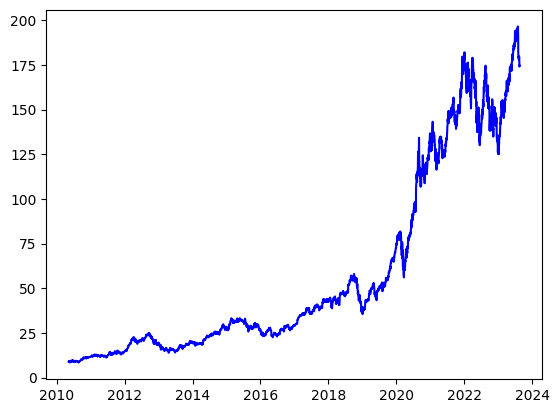

In [4]:
import matplotlib.pyplot as plt
plt.plot(df['Close'],'b')
plt.show()

In [5]:
import plotly.express as px

In [6]:
fig=px.line(df,x=df.index,y=['Open','Close'])
fig.show()

In [7]:
df_ma100=df['Close'].rolling(100).mean()

In [8]:
px.line(x=df.index,y=[df['Close'],df_ma100])

In [9]:
df_ma200=df['Close'].rolling(200).mean()

In [10]:
px.line(x=df.index,y=[df['Close'],df_ma100,df_ma200])

In [11]:
df.shape

(3343, 6)

In [55]:
df_train=df['Close'][0:int(df.shape[0]*0.7)]
df_val=df['Close'][int(df.shape[0]*0.7):int(df.shape[0]*0.8)]
df_test=df['Close'][int(df.shape[0]*0.8):]
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(2340,)
(334,)
(669,)


In [56]:
df_train=df_train.to_frame()
df_val=df_val.to_frame()
df_test=df_test.to_frame()

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
train_norm=scaler.fit_transform(df_train)
train_norm

array([[0.01170376],
       [0.01352823],
       [0.01754486],
       ...,
       [0.90192031],
       [0.90101173],
       [0.85144184]])

In [18]:
from matplotlib.rcsetup import validate_cycler
val_norm=scaler.fit_transform(df_val)
val_norm[:6]

array([[0.00700626],
       [0.        ],
       [0.00411954],
       [0.01458381],
       [0.01377196],
       [0.00463072]])

In [19]:
test_norm=scaler.fit_transform(df_test)
test_norm.shape

(669, 1)

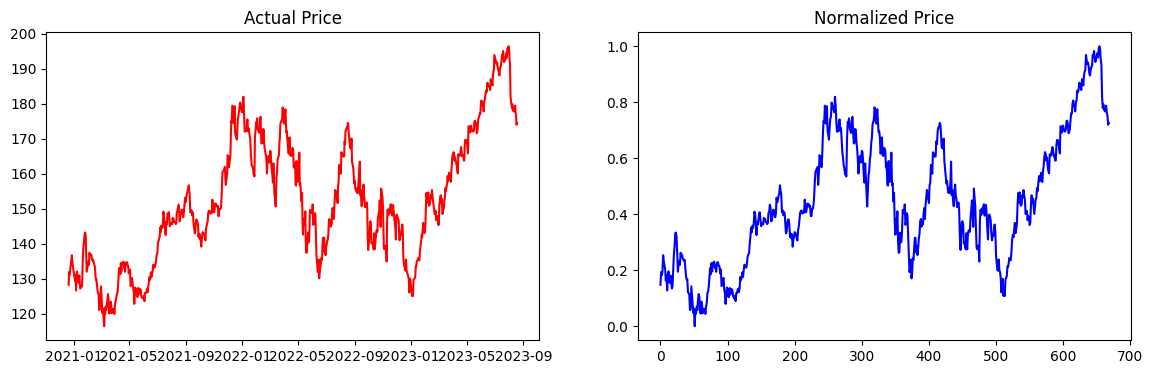

In [20]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(df_test,'r')
plt.title('Actual Price')
plt.subplot(122)
plt.plot(test_norm,'b')
plt.title('Normalized Price')
plt.show()

In [21]:
x_train=[]
y_train=[]
for i in range(100,train_norm.shape[0]):
  x_train.append(train_norm[i-100:i])
  y_train.append(train_norm[i,0])
x_train,y_train=np.array(x_train),np.array(y_train)

In [22]:
x_val=[]
y_val=[]
for i in range(100,val_norm.shape[0]):
  x_val.append(val_norm[i-100:i])
  y_val.append(val_norm[i,0])
x_val,y_val=np.array(x_val),np.array(y_val)

In [23]:
from keras.layers import Dense,Dropout,LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
model=Sequential()
model.add(LSTM(units=50,activation='relu', return_sequences=True, input_shape=(100,1)))
model.add(Dropout(0.2))
model.add(LSTM(units=60,activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=80,activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [24]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [25]:
callback=EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    mode="auto"
)

In [26]:
model.fit(x_train,  y_train, epochs=50, callbacks=[callback], validation_data=(x_val,y_val))

Epoch 1/50
70/70 [==============================] - 40s 425ms/step - loss: 0.0354 - accuracy: 0.0000e+00 - val_loss: 0.0140 - val_accuracy: 0.0043
Epoch 2/50
70/70 [==============================] - 29s 408ms/step - loss: 0.0072 - accuracy: 4.4643e-04 - val_loss: 0.0153 - val_accuracy: 0.0043
Epoch 3/50
70/70 [==============================] - 28s 406ms/step - loss: 0.0065 - accuracy: 4.4643e-04 - val_loss: 0.0148 - val_accuracy: 0.0043
Epoch 4/50
70/70 [==============================] - 30s 435ms/step - loss: 0.0061 - accuracy: 4.4643e-04 - val_loss: 0.0103 - val_accuracy: 0.0043
Epoch 5/50
70/70 [==============================] - 29s 408ms/step - loss: 0.0052 - accuracy: 4.4643e-04 - val_loss: 0.0191 - val_accuracy: 0.0043
Epoch 6/50
70/70 [==============================] - 29s 408ms/step - loss: 0.0058 - accuracy: 4.4643e-04 - val_loss: 0.0182 - val_accuracy: 0.0043
Epoch 7/50
70/70 [==============================] - 28s 402ms/step - loss: 0.0051 - accuracy: 4.4643e-04 - val_loss: 0

In [45]:
model.save('keras_model.h5')

In [46]:
from keras.models import load_model

In [47]:
model=load_model('/content/keras_model.h5')

In [53]:
past_100_days=df_val.tail(100)

In [57]:
test_df=pd.concat([past_100_days,df_test])
test_df

,Close
Date,
2020-07-30,96.190002
2020-07-31,106.260002
2020-08-03,108.937500
2020-08-04,109.665001
2020-08-05,110.062500
...,...
2023-08-14,179.460007
2023-08-15,177.449997
2023-08-16,176.570007


In [58]:
test_date=df_test.index

In [59]:
norm_test=scaler.fit_transform(test_df)

In [60]:
norm_test.shape

(769, 1)

In [61]:
x_test=[]
y_test=[]
for i in range(100,norm_test.shape[0]):
  x_test.append(norm_test[i-100:i])
  y_test.append(norm_test[i,0])
x_test,y_test=np.array(x_test),np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(669, 100, 1)
(669,)


In [62]:
y_pred=model.predict(x_test)

21/21 [==============================] - 3s 83ms/step


In [63]:
y_pred.shape

(669, 1)

In [64]:
y_pred=scaler.inverse_transform(y_pred)
y_pred.shape

(669, 1)

In [65]:
df_test.shape

(669, 1)

In [66]:
p=[i[0] for i in y_pred]

In [67]:
final_result=df_test

In [68]:
final_result['predicted']=p

In [69]:
final_result.head()

,Close,predicted
Date,,
2020-12-21,128.229996,124.213402
2020-12-22,131.880005,124.847588
2020-12-23,130.960007,125.519714
2020-12-24,131.970001,126.221748
2020-12-28,136.690002,126.950920


In [70]:
px.line(x=final_result.index,y=[final_result['Close'],final_result['predicted']])

In [71]:
whole=df['Close']
whole=whole.to_frame()

In [72]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
norm_whole=scaler.fit_transform(whole)
norm_whole

array([[0.00308388],
       [0.00356462],
       [0.00462298],
       ...,
       [0.89423206],
       [0.8805588 ],
       [0.88316579]])

In [73]:
x_whole=[]
y_whole=[]
for i in range(100,df['Close'].shape[0]):
  x_whole.append(norm_whole[i-100:i])
  y_whole.append(norm_whole[i,0])
x_whole, y_whole=np.array(x_whole), np.array(y_whole)

In [74]:
print(x_whole.shape)
print(y_whole.shape)

(3243, 100, 1)
(3243,)


In [75]:
from keras.models import load_model
model=load_model('/content/keras_model.h5')

In [76]:
whole_pred=model.predict(x_whole)

102/102 [==============================] - 7s 68ms/step


In [77]:
whole_pred=scaler.inverse_transform(whole_pred)

In [78]:
wp=[i[0] for i in whole_pred]

In [79]:
whole['Pred']=[0 for i in range(whole.shape[0])]
whole.head()

,Close,Pred
Date,,
2010-05-10,9.071071,0
2010-05-11,9.161429,0
2010-05-12,9.360357,0
2010-05-13,9.227143,0
2010-05-14,9.065000,0


In [80]:
whole['Pred'][100:]=wp
whole.tail()

<ipython-input-80-2c813f9c7e02>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Close,Pred
Date,,
2023-08-14,179.460007,180.673813
2023-08-15,177.449997,179.508301
2023-08-16,176.570007,178.526352
2023-08-17,174.000000,177.735886
2023-08-18,174.490005,177.085358


In [81]:
px.line(x=whole.index,y=[whole['Close'],whole['Pred']])